# Figure S7: Bottom temperature maps

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
import sys
sys.path.append(
    "/g/data/e14/cs6673/Ross_salinity/Python_scripts_published/") 
from Info_definitions import (
    path_database, path_plots, exptdict, yearly_mean,
    shelf_mask_isobath, select_bottom_values)

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import string

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38039,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:39159,Total threads: 4
Dashboard: /proxy/37123/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:46395,


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22515129755456 and this is thread id 22513530849024.
Exception closing connection <sqlite3.Connection object at 0x1479f6676940>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

## Load data

In [4]:
%%time
ekeys = ['ctrl', 'wind_50_down_zonal', 'mw_50_down']
start_time = '2150-01-01'
end_time = '2159-12-31'

ht = cc.querying.getvar(
    exptdict['ctrl']['expt'], 'ht',
    session=cc.database.create_session(), n=1).sel(
    yt_ocean=slice(-90, -60))
ht_shelf, shelf_mask = shelf_mask_isobath(ht, output_mask=True)
land_mask = (ht*0).fillna(1)

for ekey in ekeys:
    print(ekey)
    e = exptdict[ekey]
    if ekey == 'ctrl':
        session = cc.database.create_session()
    else:
        db = (path_database + e['expt'] + '.db')
        session = cc.database.create_session(db)
        
    e['temp'] = cc.querying.getvar(
        e['expt'], 'temp', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(None, -60), xt_ocean=slice(-240, -60)) - 273.15
    e['temp_bot'] = select_bottom_values(e['temp']).compute()

ctrl


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN s

wind_50_down_zonal
mw_50_down


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


CPU times: user 55.7 s, sys: 6.28 s, total: 1min 1s
Wall time: 2min 13s


In [5]:
def Fig_S7(ekeys, var_name, v_min=-1.8, v_max=5, v_max_diff=.6, time=None):
    
    fig, ax = plt.subplots(
            1, 3, figsize=(12, 3), subplot_kw={
                'projection': ccrs.PlateCarree(central_longitude=185)})
    plt.subplots_adjust(wspace=.35)
    proj = ccrs.PlateCarree()

    for p, ekey in enumerate(ekeys):
        ax[p].contourf(land_mask.xt_ocean, land_mask.yt_ocean,
                    land_mask, colors='silver', levels=[0.5, 2],
                    zorder=2, transform=proj)
    
        ax[p].set_extent([160, 210, -79, -69])
        gl = ax[p].gridlines(draw_labels=False)
        gl.xlocator = mticker.FixedLocator(
            [180, -160])
        ax[p].set_xticks([180, -160], crs=proj)
        ax[p].xaxis.set_major_formatter(LongitudeFormatter(
            dateline_direction_label=True))
        gl.ylocator = mticker.FixedLocator(
            np.arange(-80, -65, 5))
        if p == 0:
            ax[p].set_yticks(np.arange(-80, -65, 5), crs=proj)
        ax[p].yaxis.set_major_formatter(LatitudeFormatter())
        ax[p].set_ylim(-79, None)
        ax[p].set_aspect('auto')
    
        ax[p].contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask,
                    levels=[0, 1], colors = 'k',  transform=proj)

        e =  exptdict[ekey]
        var = e[var_name]
        if ekey == 'ctrl':
            var_ctrl = var.copy()
            var = yearly_mean(var).mean('time')
            var = var.where(var != 0)

            pc = ax[p].pcolormesh(
                var.xt_ocean, var.yt_ocean, var, cmap=cmo.thermal,
                vmin=v_min, vmax=v_max, transform=proj)
            ax[p].set_title(
                string.ascii_lowercase[p] + ') ' + e['expt_str'],
                fontweight='bold', loc='left')
        else:
            var = var - var_ctrl
            var = yearly_mean(var).mean('time')

            pc = ax[p].pcolormesh(
                var.xt_ocean, var.yt_ocean, var, cmap=cmo.balance,
                vmin=-v_max_diff, vmax=v_max_diff, transform=proj)
            ax[p].set_title(
                string.ascii_lowercase[p] + ') ' + e['expt_str'] + '  -  ' +
                exptdict['ctrl']['expt_str'], fontweight='bold', loc='left')
        
        pos = ax[p].get_position()
        cax = plt.axes([pos.xmax+.007, pos.ymin,
                        0.015, pos.ymax-pos.ymin])
        cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
        if var_name[:4] == 'temp':
            unit = '°C'
        elif var_name[:4] == 'salt':
            unit = 'psu'
        elif var_name[:4] == 'rho0':
            unit = 'kg m$^{-3}$'
        cb.ax.set_title(unit)
    
    # plt.savefig(path_plots + 'FigS7.png', dpi=300, bbox_inches="tight")
    plt.show()

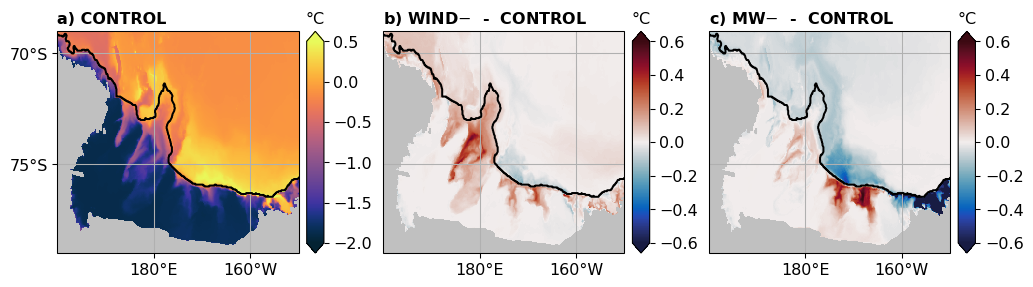

In [6]:
var_name = 'temp_bot'
v_min = -2
v_max = .5
v_max_diff = .6
time_slice = slice('2155-01', '2159-12')
Fig_S7(ekeys, var_name, v_min, v_max, v_max_diff, time_slice)